In [1]:
import pandas as pd
import re
import unicodedata
import seaborn as sns
import spacy
import matplotlib.pyplot as plt
from nltk.probability import FreqDist # This is for counting the most frequent words
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize # this is for counting the senteces
plt.style.use('ggplot')

from collections import Counter
from functools import reduce
import language_tool_python
import lmppl

import warnings
warnings.filterwarnings('ignore')

# EDA of "GPT vs. Human: A Corpus of Research Abstracts"

In [2]:
data = pd.read_csv("data_set.csv" , index_col= False )
data.head(5)

,title,abstract,ai_generated,is_ai_generated
0,Are Advanced Potentials Anomalous?,Advanced electromagnetic potentials are indi...,False,0
1,Are Advanced Potentials Anomalous?,This research paper investigates the question ...,True,1
2,An efficient centralized binary multicast netw...,We give an algorithm for finding network enc...,False,0
3,An efficient centralized binary multicast netw...,The paper presents an efficient centralized bi...,True,1
4,Percolation transition in networks with degree...,We introduce an exponential random graph mod...,False,0


In [3]:
print(data.shape)
data.info()
# This dataset is bigger than the other one

(4053, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4053 entries, 0 to 4052
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            4053 non-null   object
 1   abstract         4053 non-null   object
 2   ai_generated     4053 non-null   bool  
 3   is_ai_generated  4053 non-null   int64 
dtypes: bool(1), int64(1), object(2)
memory usage: 99.1+ KB


In [4]:
# Checking missing values...
data.isna().sum()
# No Missing values as before

title              0
abstract           0
ai_generated       0
is_ai_generated    0
dtype: int64

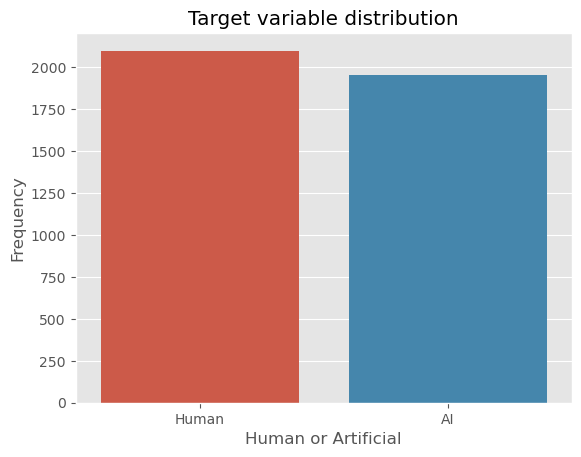

In [5]:
# What about the target class distro? It should be totally balanced because for every question we have 2 answers
fig = sns.countplot(data, x = 'ai_generated')
fig.set(title = 'Target variable distribution', xlabel = 'Human or Artificial', ylabel = 'Frequency', xticklabels=['Human','AI'] )
plt.show()
# There are a bit less AI responses

## EDA --> Counts and lengths

### Character Count

In [6]:
def article_length(text):
    return len(text)
data['length'] = data['abstract'].apply(article_length) 
print(data[data['is_ai_generated']==0].length.mean())
print(data[data['is_ai_generated']==1].length.mean())

911.6428571428571
790.5340501792115


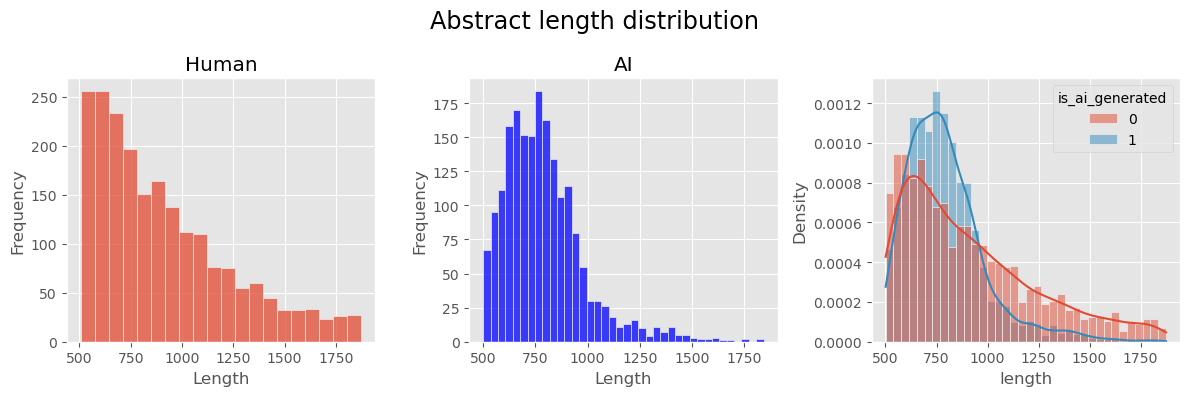

In [7]:
fig, axes = plt.subplots(1,3, figsize = (12,4))
fig_dist_human = sns.histplot(data = data[data['is_ai_generated']==0], x = 'length', ax = axes[0])
fig_dist_human.set(title = 'Human', xlabel='Length', ylabel= 'Frequency')
fig_dist_ai = sns.histplot(data = data[data['is_ai_generated']==1], x = 'length', ax = axes[1], color = 'blue')
fig_dist_ai.set(title = 'AI', xlabel='Length', ylabel= 'Frequency')
fig.suptitle('Abstract length distribution', fontsize =  'xx-large')
sns.histplot(data = data, x = 'length', hue='is_ai_generated', kde= True, stat = 'density', ax = axes[2] ) # Overlapped
plt.tight_layout()

### Words Count

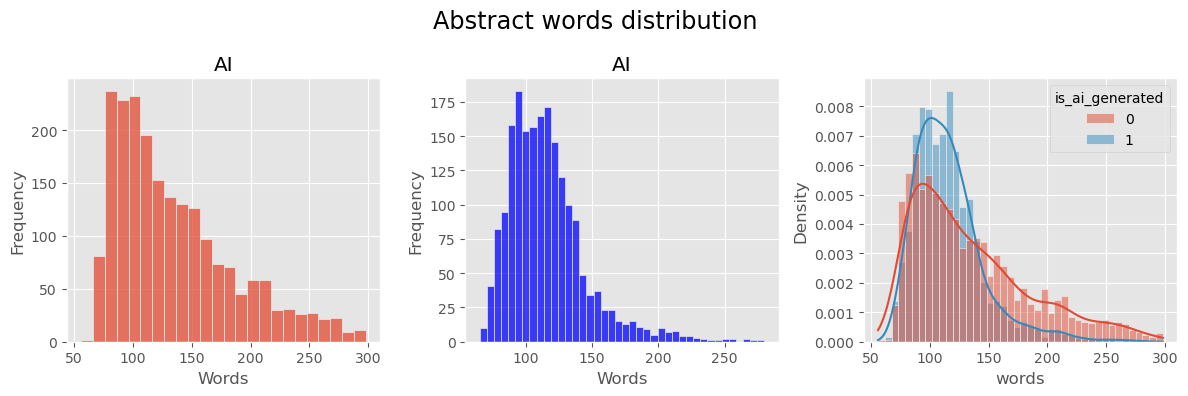

In [8]:
data['words'] = data['abstract'].apply(lambda x: len(str(x).split()))
figg, axes = plt.subplots(1,3, figsize = (12,4))
fig_dist_human = sns.histplot(data = data[data['is_ai_generated']==0], x = 'words', ax = axes[0])
fig_dist_human.set(title = 'AI', xlabel='Words', ylabel= 'Frequency')
fig_dist_ai = sns.histplot(data = data[data['is_ai_generated']==1], x = 'words', ax = axes[1], color='blue')
fig_dist_ai.set(title = 'AI', xlabel='Words', ylabel= 'Frequency')
sns.histplot(data = data, x = 'words', hue='is_ai_generated', kde= True, stat = 'density', ax = axes[2]) 
figg.suptitle('Abstract words distribution', fontsize =  'xx-large')
plt.tight_layout()

### Sentences Count

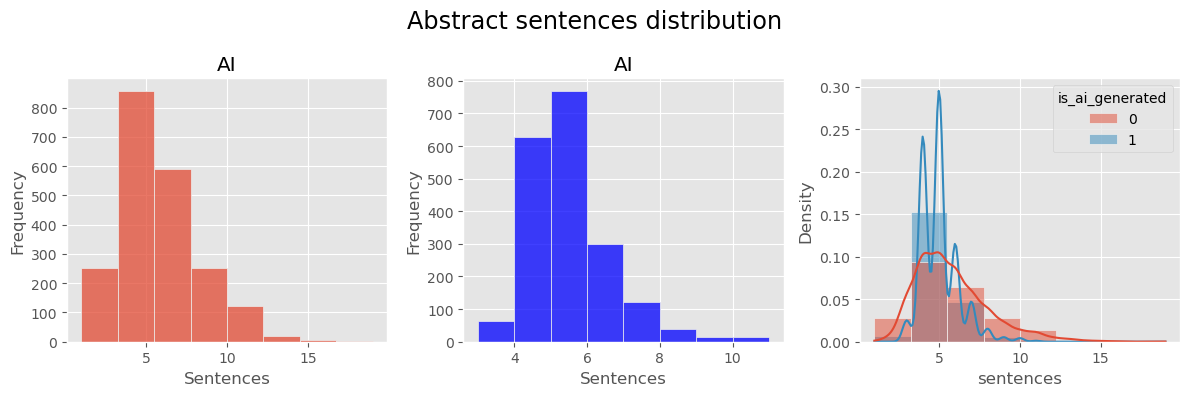

In [9]:
data['sentences'] = data['abstract'].map(lambda x: len(sent_tokenize(x)))
fig, axes = plt.subplots(1,3, figsize = (12,4))
fig_sentences_human = sns.histplot(data = data[data['is_ai_generated']==0], x = 'sentences', ax = axes[0], bins = 8)
fig_sentences_human.set(title = 'AI', xlabel='Sentences', ylabel= 'Frequency')
fig_sentences_ai = sns.histplot(data = data[data['is_ai_generated']==1], x = 'sentences', ax = axes[1], color='blue',bins = 8)
fig_sentences_ai.set(title = 'AI', xlabel='Sentences', ylabel= 'Frequency')
sns.histplot(data = data, x = 'sentences', hue='is_ai_generated', kde= True, stat = 'density', ax = axes[2], bins = 8) 
fig.suptitle('Abstract sentences distribution', fontsize =  'xx-large')
plt.tight_layout()

# EDA --> Term frequency analysis

Steps we will follow:
1) Convert to lowercase
2) remove urls and html tags if any
3) Remove strange acceted characters if any
4) Remove punctuation
5) Remove extra white spaces 
6) Delet stop words

In [10]:
# Our functions
def lowering(text):
    return text.lower()

def remove_url(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

def remove_accents(text):
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

def remove_punctuation(text):
    return re.sub(r'[^a-zA-Z0-9]', ' ', text)

def remove_extra_spaces(text):
    return re.sub(r'^\s*|\s\s*', ' ', text).strip()

en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words
def delete_stopwords(text):
    words = [word for word in text.split() if word.lower() not in sw_spacy]
    new_text = " ".join(words)
    return new_text

In [11]:
len(data[data.abstract.str.contains('http')]) #only 4

4

In [12]:
data['abstract_clean'] = data.abstract.apply(lowering)   
data['abstract_clean'] = data.abstract_clean.apply(remove_url)
data['abstract_clean'] = data.abstract_clean.apply(remove_accents)
data['abstract_clean'] = data.abstract_clean.apply(remove_punctuation)
data['abstract_clean'] = data.abstract_clean.apply(remove_extra_spaces)
data['abstract_nopunct'] = data.abstract_clean.copy()
data['abstract_clean'] = data.abstract_clean.apply(delete_stopwords)

#### Most common words

In [13]:
def most_common_words(data):
    corpus = [word for i in data['abstract_clean'].str.split().values.tolist() for word in i]
    most_common = FreqDist(corpus).most_common(40)
    words, frequency = [], []
    for word, count in most_common:
        words.append(word)
        frequency.append(count)   
    return dict(zip(words, frequency))
most_1_human = most_common_words(data[data['is_ai_generated']==0])
most_1_ai = most_common_words(data[data['is_ai_generated']==1])

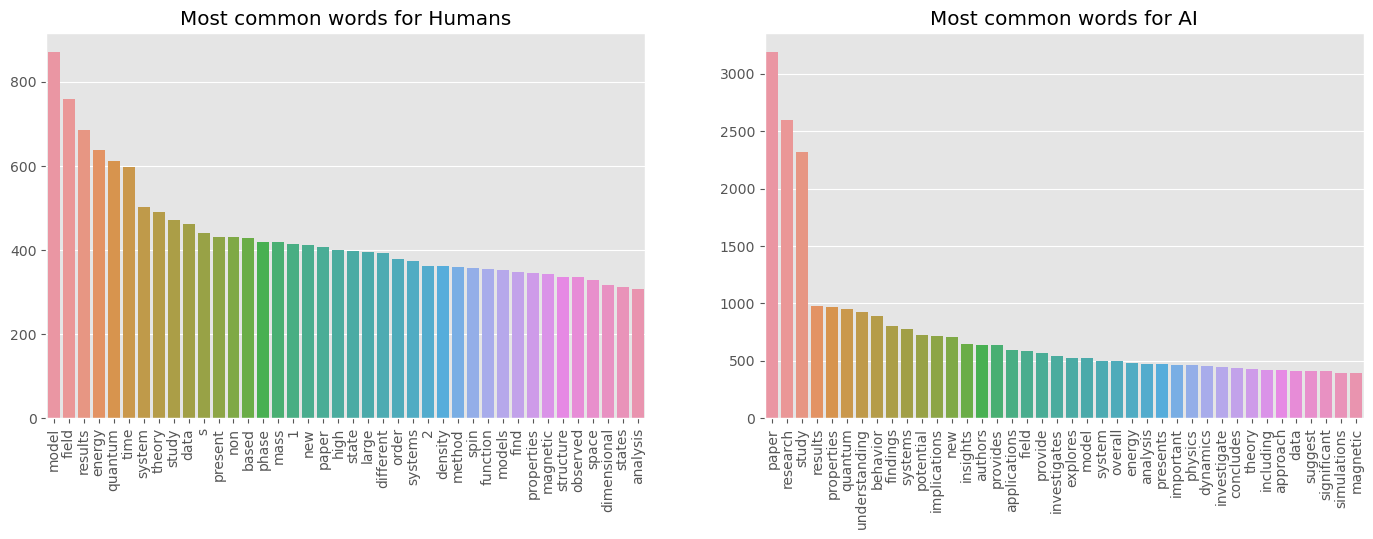

In [14]:
fig, axes = plt.subplots(1,2, figsize = (17,5))
sns.barplot(x = list(most_1_human.keys()), y = list(most_1_human.values()), ax = axes[0]).set(title="Most common words for Humans")
sns.barplot(x = list(most_1_ai.keys()), y = list(most_1_ai.values()), ax = axes[1]).set(title="Most common words for AI")
axes[0].tick_params(axis='x', rotation = 90)
axes[1].tick_params(axis='x', rotation = 90)
plt.show()

#### Bigrams

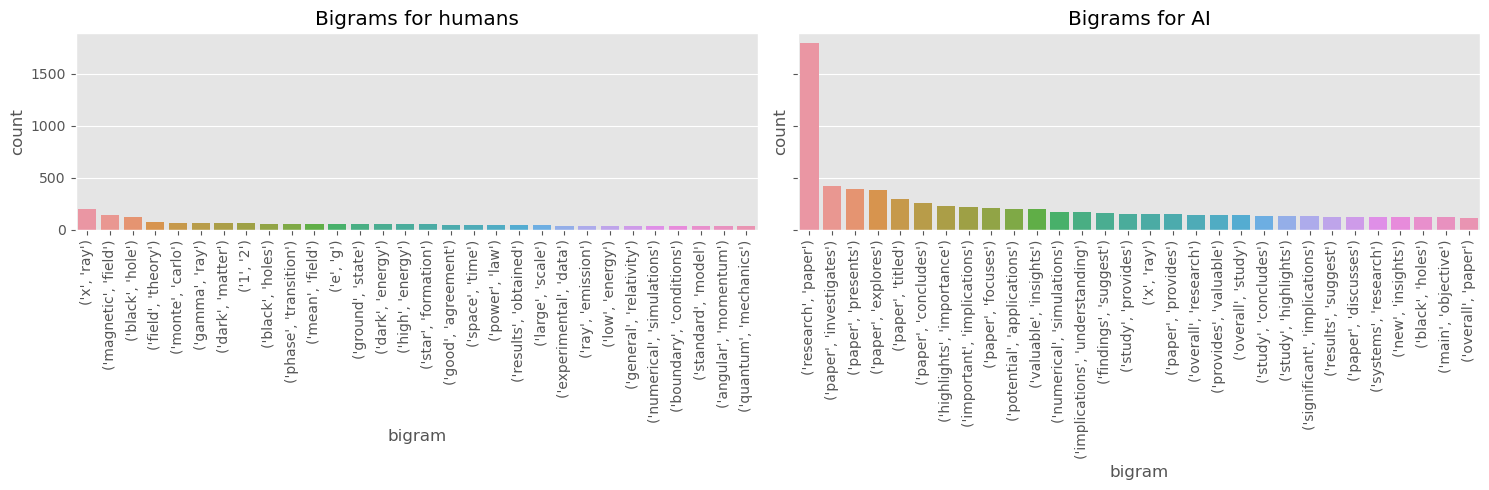

In [15]:
humans = data[data['is_ai_generated']==0]
corpus_humans = [word for i in humans.abstract_clean.str.split().values.tolist() for word in i]
bigrams_humans = (pd.Series(nltk.ngrams(corpus_humans, 2)).value_counts())
bigrams_df_h = bigrams_humans.reset_index()
bigrams_df_h.columns = ['bigram', 'count']

AI = data[data['is_ai_generated']==1]
corpus_AI = [word for i in AI.abstract_clean.str.split().values.tolist() for word in i]
bigrams_AI = (pd.Series(nltk.ngrams(corpus_AI, 2)).value_counts())
bigrams_df_AI = bigrams_AI.reset_index()
bigrams_df_AI.columns = ['bigram', 'count']

fig, axes = plt.subplots(1,2, figsize = (15,5), sharey=True)
sns.barplot(bigrams_df_h.head(30), x = 'bigram', y ='count', ax=axes[0]).set(title = 'Bigrams for humans')
sns.barplot(bigrams_df_AI.head(30), x = 'bigram', y ='count', ax=axes[1]).set(title = 'Bigrams for AI')
axes[0].tick_params(axis='x', rotation = 90)
axes[1].tick_params(axis='x', rotation = 90)
plt.tight_layout()

#### Trigrams

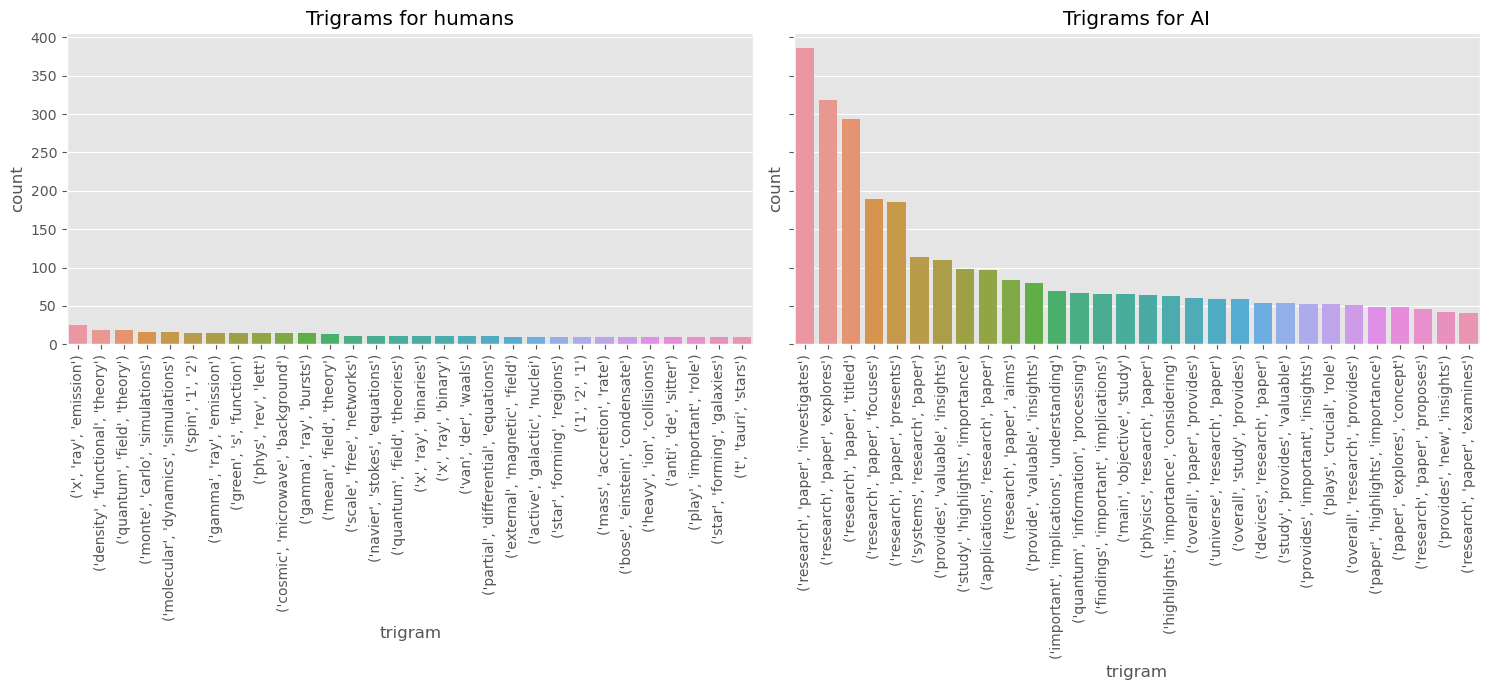

In [16]:
trigrams_humans = (pd.Series(nltk.ngrams(corpus_humans, 3)).value_counts())
trigrams_df_h = trigrams_humans.reset_index()
trigrams_df_h.columns = ['trigram', 'count']

trigrams_AI = (pd.Series(nltk.ngrams(corpus_AI, 3)).value_counts())
trigrams_df_AI = trigrams_AI.reset_index()
trigrams_df_AI.columns = ['trigram', 'count']

fig, axes = plt.subplots(1,2, figsize = (15,7), sharey= True) 
sns.barplot(trigrams_df_h.head(30), x = 'trigram', y ='count', ax=axes[0]).set(title = 'Trigrams for humans')
sns.barplot(trigrams_df_AI.head(30), x = 'trigram', y ='count', ax=axes[1]).set(title = 'Trigrams for AI')
axes[0].tick_params(axis='x', rotation = 90)
axes[1].tick_params(axis='x', rotation = 90)
plt.tight_layout()

# New column

In [17]:
corpus = [word for i in data.abstract_clean.str.split().values.tolist() for word in i]
bigram = (pd.Series(nltk.ngrams(corpus, 2)).value_counts())
unique_bigrams = bigram.head(50).index.tolist()
data['total_bigram_count'] = 0

In [18]:
def sum_bigram_counts(row):
    words = row['abstract_clean'].split()
    row_bigrams = list(nltk.ngrams(words, 2))
    
    # if the bigram is one of the 50 most frequent and if it is in the row sum 1
    row_count = sum(1 for bigram in row_bigrams if bigram in unique_bigrams)
    
    row['total_bigram_count'] = row_count

    return row

In [19]:
data = data.apply(sum_bigram_counts, axis=1)
data

,title,abstract,ai_generated,is_ai_generated,length,words,sentences,abstract_clean,abstract_nopunct,total_bigram_count
0,Are Advanced Potentials Anomalous?,Advanced electromagnetic potentials are indi...,False,0,1157,164,7,advanced electromagnetic potentials indigenous...,advanced electromagnetic potentials are indige...,0
1,Are Advanced Potentials Anomalous?,This research paper investigates the question ...,True,1,642,93,5,research paper investigates question advanced ...,this research paper investigates the question ...,5
2,An efficient centralized binary multicast netw...,We give an algorithm for finding network enc...,False,0,507,77,4,algorithm finding network encoding decoding eq...,we give an algorithm for finding network encod...,0
3,An efficient centralized binary multicast netw...,The paper presents an efficient centralized bi...,True,1,940,125,6,paper presents efficient centralized binary mu...,the paper presents an efficient centralized bi...,2
4,Percolation transition in networks with degree...,We introduce an exponential random graph mod...,False,0,966,139,6,introduce exponential random graph model netwo...,we introduce an exponential random graph model...,1
...,...,...,...,...,...,...,...,...,...,...
4048,Vortex Dynamics at the Initial Stage of Resist...,This research paper investigates the vortex dy...,True,1,597,90,4,research paper investigates vortex dynamics su...,this research paper investigates the vortex dy...,3
4049,The Veldkamp Space of Two-Qubits,Given a remarkable representation of the gen...,False,0,590,91,2,given remarkable representation generalized pa...,given a remarkable representation of the gener...,0
4050,The Veldkamp Space of Two-Qubits,The Veldkamp space of two-qubits is a mathemat...,True,1,901,130,6,veldkamp space qubits mathematical object desc...,the veldkamp space of two qubits is a mathemat...,4
4051,Fusion process studied with preequilibrium gia...,The equilibration of macroscopic degrees of ...,False,0,1069,163,8,equilibration macroscopic degrees freedom fusi...,the equilibration of macroscopic degrees of fr...,1


____________

# Features Extraction

List of features to extract: 
1. Features that identify diversity and richness in the vocabulary (if we have to choose, keep Herdan's C, it's the best one for the task according to a paper)
    - Herdan's C
    - MaaS
    - Simpson's index

2. Perplexity distribution
3. Grammar Score 
4. N-grams distribution -> in the end no: it's shit to be summarized (the means are all low and don't make distinctions between Human and AI)
5. Type Token Ratio (TTR) on N-grams for N=1,2,3
6. Length (article - level: done in the eda, column 'words')
7. Average token length


Everything done on partially pre-procesed articles: only no punctuation but we keep the stopwords.

Before getting the features, we add some columns to the dataset that containg infromations needed to compute more then one feature. We will drop these columns afterwards. 

In [20]:
# article_clean as a list, useful
data['abstract_list'] = data.abstract_nopunct.apply(str.split)


Computing the vocabulary

In [21]:
vocabulary = Counter(reduce(lambda x,y : x+y, data.abstract_list.values))

# get the vocabulary length and its log (for Herdan's C and MaaS)
voc_len = len(vocabulary)
log_voc_len = np.log(voc_len)


In [22]:
# Herdan's C
data['herdan'] = data.words.apply(lambda row: log_voc_len/np.log(row))

# MaaS
data['maas'] = data.words.apply(lambda row: (log_voc_len - np.log(row)) / np.log((voc_len**2)) )

# Simpson's index 
data['tf'] = data.abstract_list.apply(lambda row: Counter(row))
data['tf'] = data.tf.apply(lambda row: row.values())
simpson_help = zip(data.tf, list(data.words))
data['simpson'] = list(simpson_help)
data['simpson'] = data.simpson.apply(lambda row: [(val/row[1])**2 for val in row[0]]).apply(lambda row: 1-sum(row))

# Grammar score 
tool = language_tool_python.LanguageTool('en-US')
data['grammar_score'] = data.abstract.apply(lambda row: len(tool.check(row))) #number of errors per row
grammar_score_help = zip(data.grammar_score, data.words)
data['grammar_score'] = list(grammar_score_help)
data['grammar_score'] = data.grammar_score.apply(lambda row: (row[0]/row[1]) ) #compute grammar score

# TTR on the whole text = on 1-grams (saved as TTR1)
# for this section: type = len(tf), token = words
data['TTR1'] = list(zip(list(data.tf.apply(len)), data.words))  #assign (type, token) as value for each row
data['TTR1'] = data.TTR1.apply(lambda row: row[0]/row[1])       #compute TTR

# TTR on 2-grams, prevalence of 2grams
data['bigrams'] = data.abstract_clean.apply(str.split).apply(lambda row: nltk.ngrams(row, 2)) #create bigrams for each document
data['prevalence2'] = data.bigrams.apply(Counter                                     #count the occurency of each bigram
                                  ).apply(lambda row: (len(row), sum(row.values()) ) #returns (type, token) couple for each row
                                  ).apply(lambda row: row[0]/row[1] )                #computes TTR


#TTR on 3-grams, prevalence of trigrams
data['trigrams'] = data.abstract_clean.apply(str.split).apply(lambda row: nltk.ngrams(row, 3)) #create bigrams for each document
data['prevalence3'] = data.trigrams.apply(Counter                                    #count the occurencies of each trigram
                                  ).apply(lambda row: (len(row), sum(row.values()) ) #returns (type, token) couple for each row
                                  ).apply(lambda row: row[0]/row[1] )                #computes TTR


# Average token length 
data['avg_token_length'] = data.abstract_list.apply(lambda row: [len(word) for word in row]).apply(lambda row: sum(row)/len(row))


In [28]:

scorer = lmppl.LM('gpt2')

Using pad_token, but it is not set yet.
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embeding dimension will be 50258. This might induce some performance reduction as *Tensor Cores* will not be available. For more details  about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


In [30]:
data['perplexity'] = data.abstract.apply(scorer.get_perplexity)

100%|██████████| 1/1 [00:00<00:00,  6.56it/s]


In [31]:
data

,title,abstract,ai_generated,is_ai_generated,length,words,sentences,abstract_clean,abstract_nopunct,total_bigram_count,abstract_list,herdan,maas,simpson,grammar_score,TTR1,prevalence2,prevalence3,avg_token_length,perplexity
0,Are Advanced Potentials Anomalous?,Advanced electromagnetic potentials are indi...,False,0,1157,164,7,advanced electromagnetic potentials indigenous...,advanced electromagnetic potentials are indige...,0,"[advanced, electromagnetic, potentials, are, i...",1.907805,0.237919,0.981187,0.006098,0.646341,0.977011,1.000000,5.617647,231.341695
1,Are Advanced Potentials Anomalous?,This research paper investigates the question ...,True,1,642,93,5,research paper investigates question advanced ...,this research paper investigates the question ...,5,"[this, research, paper, investigates, the, que...",2.146572,0.267070,0.974217,0.010753,0.688172,0.895833,0.978723,5.849462,11.742700
2,An efficient centralized binary multicast netw...,We give an algorithm for finding network enc...,False,0,507,77,4,algorithm finding network encoding decoding eq...,we give an algorithm for finding network encod...,0,"[we, give, an, algorithm, for, finding, networ...",2.239868,0.276773,0.972677,0.012987,0.740260,1.000000,1.000000,5.217949,280.127898
3,An efficient centralized binary multicast netw...,The paper presents an efficient centralized bi...,True,1,940,125,6,paper presents efficient centralized binary mu...,the paper presents an efficient centralized bi...,2,"[the, paper, presents, an, efficient, centrali...",2.015103,0.251874,0.974208,0.000000,0.608000,0.950000,1.000000,6.456000,19.123901
4,Percolation transition in networks with degree...,We introduce an exponential random graph mod...,False,0,966,139,6,introduce exponential random graph model netwo...,we introduce an exponential random graph model...,1,"[we, introduce, an, exponential, random, graph...",1.971750,0.246418,0.966979,0.021583,0.575540,0.924051,0.987179,5.562500,167.288998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4048,Vortex Dynamics at the Initial Stage of Resist...,This research paper investigates the vortex dy...,True,1,597,90,4,research paper investigates vortex dynamics su...,this research paper investigates the vortex dy...,3,"[this, research, paper, investigates, the, vor...",2.162214,0.268756,0.949630,0.000000,0.566667,0.851064,0.956522,5.600000,15.622576
4049,The Veldkamp Space of Two-Qubits,Given a remarkable representation of the gen...,False,0,590,91,2,given remarkable representation generalized pa...,given a remarkable representation of the gener...,0,"[given, a, remarkable, representation, of, the...",2.156917,0.268188,0.958097,0.098901,0.637363,0.940000,1.000000,4.835052,187.516293
4050,The Veldkamp Space of Two-Qubits,The Veldkamp space of two-qubits is a mathemat...,True,1,901,130,6,veldkamp space qubits mathematical object desc...,the veldkamp space of two qubits is a mathemat...,4,"[the, veldkamp, space, of, two, qubits, is, a,...",1.998866,0.249858,0.965976,0.053846,0.561538,0.929577,0.985714,5.706767,11.431381
4051,Fusion process studied with preequilibrium gia...,The equilibration of macroscopic degrees of ...,False,0,1069,163,8,equilibration macroscopic degrees freedom fusi...,the equilibration of macroscopic degrees of fr...,1,"[the, equilibration, of, macroscopic, degrees,...",1.910096,0.238233,0.974406,0.049080,0.656442,0.946237,0.989130,5.029070,174.794739


In [23]:
data.drop('bigrams', axis=1, inplace=True)
data.drop('trigrams', axis=1, inplace=True)
data.drop('tf', axis=1, inplace=True )

In [32]:
data.to_csv('data4000_withfeatures.csv')

In [25]:
def 

SyntaxError: invalid syntax (1885169875.py, line 1)

_________

# EDA of "ChatGPT Classification Dataset"
#### Kaggle description
We have compiled a dataset that consists of textual articles including common terminology, concepts and definitions in the field of computer science, artificial intelligence, and cyber security. This dataset consists of both human-generated text and OpenAI’s ChatGPT-generated text. Human-generated answers were collected from different computer science dictionaries and encyclopedias including “The Encyclopedia of Computer Science and Technology” and "Encyclopedia of Human-Computer Interaction". AI-generated content in our dataset was produced by simply posting questions to OpenAI’s ChatGPT and manually documenting the resulting responses. A rigorous data-cleaning process has been performed to remove unwanted Unicode characters, styling and formatting tags. To structure our dataset for binary classification, we combined both AI-generated and Human-generated answers into a single column and assigned appropriate labels to each data point (Human-generated = 0 and AI-generated = 1).

This creates our article-level dataset (article_level_data.csv) which consists of a total of 1018 articles, 509 AI-generated and 509 Human-generated. Additionally, we have divided each article into its sentences and labelled them accordingly. This is mainly to evaluate the performance of classification models and pipelines when it comes to shorter sentence-level data points. This constructs our sentence-level dataset (sentence_level_data.csv) which consists of a total of 7344 entries (4008 AI-generated and 3336 Human-generated). 

In [ ]:
data = pd.read_csv("article_level_data.csv" , index_col= False )
data.drop(columns=["Unnamed: 0"])
data.head(5)

,Unnamed: 0,article,class
0,0,NLP is a multidisciplinary field that draws fr...,0
1,1,There are a variety of emerging applications f...,0
2,2,As each new means of communication and social ...,0
3,3,"These suggestions include:, Learn about the pu...",0
4,4,In recent years there has been growing concern...,0


In [ ]:
print(data.shape)
data.info()

(1018, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1018 entries, 0 to 1017
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1018 non-null   int64 
 1   article     1018 non-null   object
 2   class       1018 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 24.0+ KB


In [ ]:
# Checking missing values...
data.isna().sum()

Unnamed: 0    0
article       0
class         0
dtype: int64

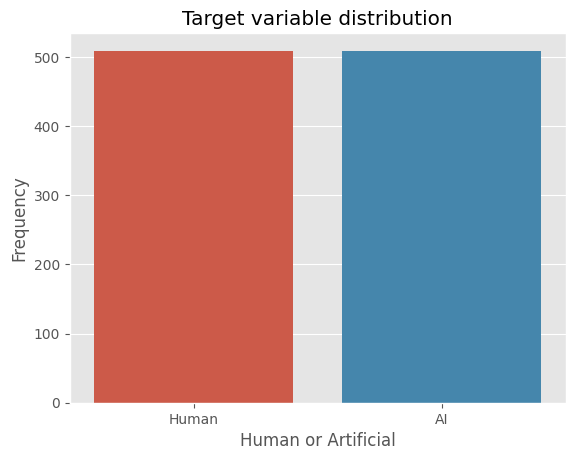

In [ ]:
# Let's see the target class distribution
fig = sns.countplot(data, x = 'class')
fig.set(title = 'Target variable distribution', xlabel = 'Human or Artificial', ylabel = 'Frequency', xticklabels=['Human','AI'] )
plt.show()
# We have a very balanced dataset

# EDA --> Counts and lengths

#### Character Count

In [ ]:
def article_length(text):
    return len(text)

data['length'] = data['article'].apply(article_length) 

In [ ]:
print(data[data['class']==0].length.mean())
print(data[data['class']==1].length.mean())
# Not a big difference in the article's length

905.5795677799607
1124.7976424361493


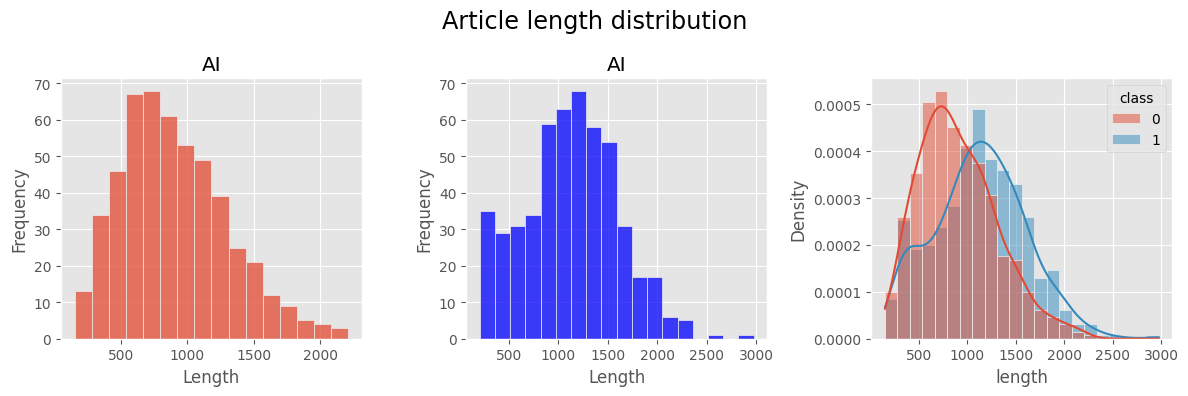

In [ ]:
fig, axes = plt.subplots(1,3, figsize = (12,4))
fig_dist_human = sns.histplot(data = data[data['class']==0], x = 'length', ax = axes[0])
fig_dist_human.set(title = 'AI', xlabel='Length', ylabel= 'Frequency')
fig_dist_ai = sns.histplot(data = data[data['class']==1], x = 'length', ax = axes[1], color = 'blue')
fig_dist_ai.set(title = 'AI', xlabel='Length', ylabel= 'Frequency')
fig.suptitle('Article length distribution', fontsize =  'xx-large')
sns.histplot(data = data, x = 'length', hue="class", kde= True, stat = 'density', ax = axes[2] ) # Overlapped
plt.tight_layout()
# We can see that the AI articles are a bit longer but not so much

#### Words count

In [ ]:
data['words'] = data['article'].apply(lambda x: len(str(x).split()))

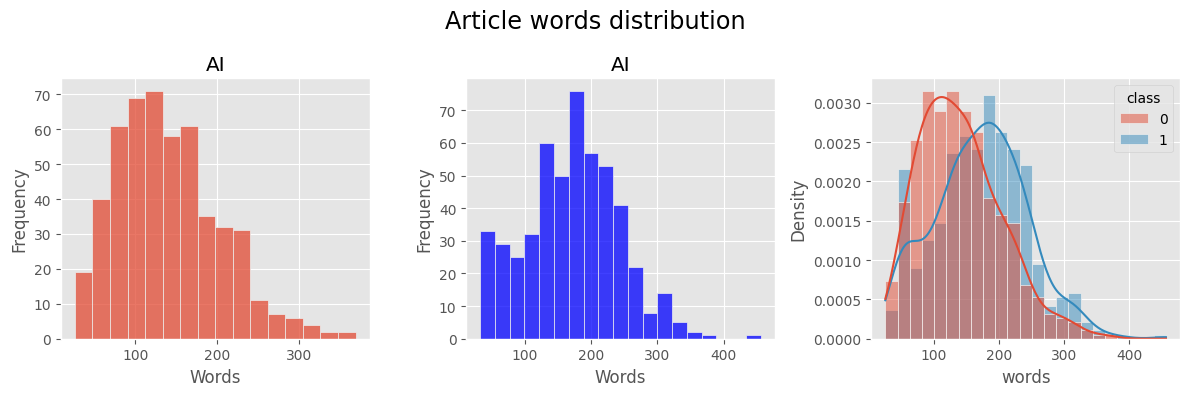

In [ ]:
figg, axes = plt.subplots(1,3, figsize = (12,4))
fig_dist_human = sns.histplot(data = data[data['class']==0], x = 'words', ax = axes[0])
fig_dist_human.set(title = 'AI', xlabel='Words', ylabel= 'Frequency')
fig_dist_ai = sns.histplot(data = data[data['class']==1], x = 'words', ax = axes[1], color='blue')
fig_dist_ai.set(title = 'AI', xlabel='Words', ylabel= 'Frequency')
sns.histplot(data = data, x = 'words', hue='class', kde= True, stat = 'density', ax = axes[2]) 
figg.suptitle('Article words distribution', fontsize =  'xx-large')
plt.tight_layout()

# It is not the same as before, the x-axis is different! But of course they are similar because we are counting the words and the lenghts

#### Sentence Count

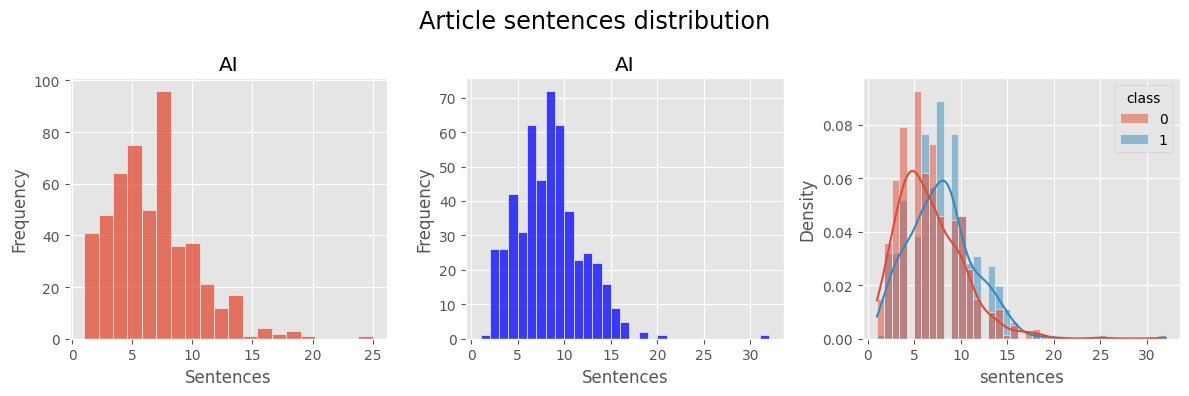

In [ ]:
data['sentences'] = data['article'].map(lambda x: len(sent_tokenize(x)))
fig, axes = plt.subplots(1,3, figsize = (12,4))
fig_sentences_human = sns.histplot(data = data[data['class']==0], x = 'sentences', ax = axes[0])
fig_sentences_human.set(title = 'AI', xlabel='Sentences', ylabel= 'Frequency')
fig_sentences_ai = sns.histplot(data = data[data['class']==1], x = 'sentences', ax = axes[1], color='blue')
fig_sentences_ai.set(title = 'AI', xlabel='Sentences', ylabel= 'Frequency')
sns.histplot(data = data, x = 'sentences', hue='class', kde= True, stat = 'density', ax = axes[2]) 
fig.suptitle('Article sentences distribution', fontsize =  'xx-large')
plt.tight_layout()

# EDA --> Term frequency analysis

Steps I will follow:
1) Convert to lowercase
2) remove urls and html tags if any
3) Remove strange acceted characters if any
4) Remove punctuation
5) Remove extra white spaces 
6) Delet stop words

In [ ]:
def lowering(text):
    return text.lower()

data['article_clean'] = data.article.apply(lowering)   

In [ ]:
len(data[data.article_clean.str.contains('http')]) # there are 23 links, we can remove or not them, to be decided

23

In [ ]:
def remove_url(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

data['article_clean'] = data.article_clean.apply(remove_url)

In [ ]:
def remove_accents(text):
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

data['article_clean'] = data.article_clean.apply(remove_accents)

In [ ]:
def remove_punctuation(text):
    return re.sub(r'[^a-zA-Z0-9]', ' ', text)

data['article_clean'] = data.article_clean.apply(remove_punctuation)

In [ ]:
def remove_extra_spaces(text):
    return re.sub(r'^\s*|\s\s*', ' ', text).strip()

data['article_clean'] = data.article_clean.apply(remove_extra_spaces)

In [ ]:
# Spacy: 326 words to eliminate
en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words

In [ ]:
# Delete stop words
def delete_stopwords(text):
    words = [word for word in text.split() if word.lower() not in sw_spacy]
    new_text = " ".join(words)
    return new_text

# Create new columns with new text and new length
data['article_clean'] = data.article_clean.apply(delete_stopwords)

In [ ]:
def most_common_words(data):
    corpus = [word for i in data['article_clean'].str.split().values.tolist() for word in i]
    most_common = FreqDist(corpus).most_common(40)
    words, frequency = [], []
    for word, count in most_common:
        words.append(word)
        frequency.append(count)   
    return dict(zip(words, frequency))

In [ ]:
most_1_human = most_common_words(data[data['class']==0])
most_1_ai = most_common_words(data[data['class']==1])

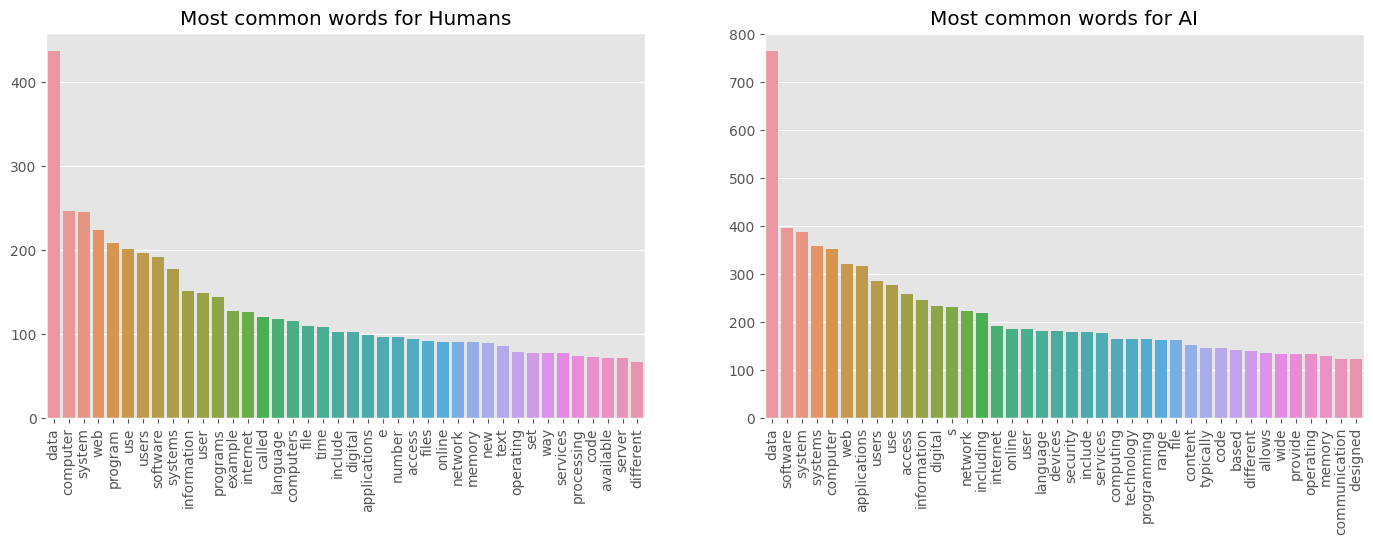

In [ ]:
fig, axes = plt.subplots(1,2, figsize = (17,5))
sns.barplot(x = list(most_1_human.keys()), y = list(most_1_human.values()), ax = axes[0]).set(title="Most common words for Humans")
sns.barplot(x = list(most_1_ai.keys()), y = list(most_1_ai.values()), ax = axes[1]).set(title="Most common words for AI")
axes[0].tick_params(axis='x', rotation = 90)
axes[1].tick_params(axis='x', rotation = 90)
plt.show()

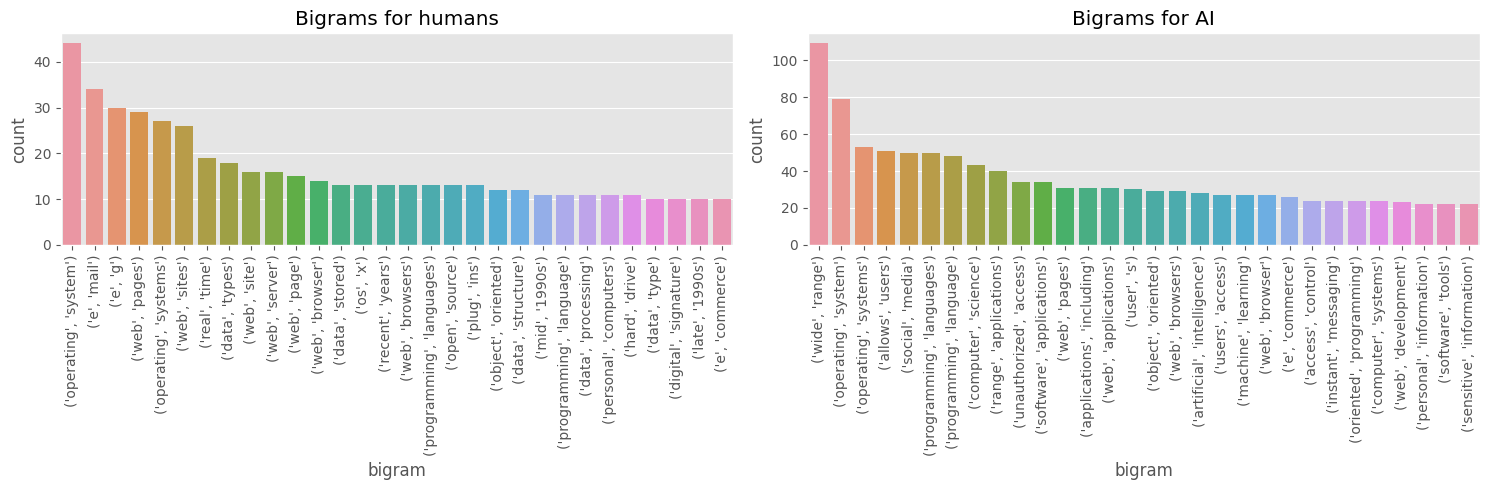

In [ ]:
humans = data[data['class']==0]
corpus_humans = [word for i in humans.article_clean.str.split().values.tolist() for word in i]
bigrams_humans = (pd.Series(nltk.ngrams(corpus_humans, 2)).value_counts())
bigrams_df_h = bigrams_humans.reset_index()
bigrams_df_h.columns = ['bigram', 'count']

AI = data[data['class']==1]
corpus_AI = [word for i in AI.article_clean.str.split().values.tolist() for word in i]
bigrams_AI = (pd.Series(nltk.ngrams(corpus_AI, 2)).value_counts())
bigrams_df_AI = bigrams_AI.reset_index()
bigrams_df_AI.columns = ['bigram', 'count']

fig, axes = plt.subplots(1,2, figsize = (15,5))
sns.barplot(bigrams_df_h.head(30), x = 'bigram', y ='count', ax=axes[0]).set(title = 'Bigrams for humans')
sns.barplot(bigrams_df_AI.head(30), x = 'bigram', y ='count', ax=axes[1]).set(title = 'Bigrams for AI')
axes[0].tick_params(axis='x', rotation = 90)
axes[1].tick_params(axis='x', rotation = 90)
plt.tight_layout()

# Look! AI has very high frequences while humans at max 40 but I still need to fix tha data :)

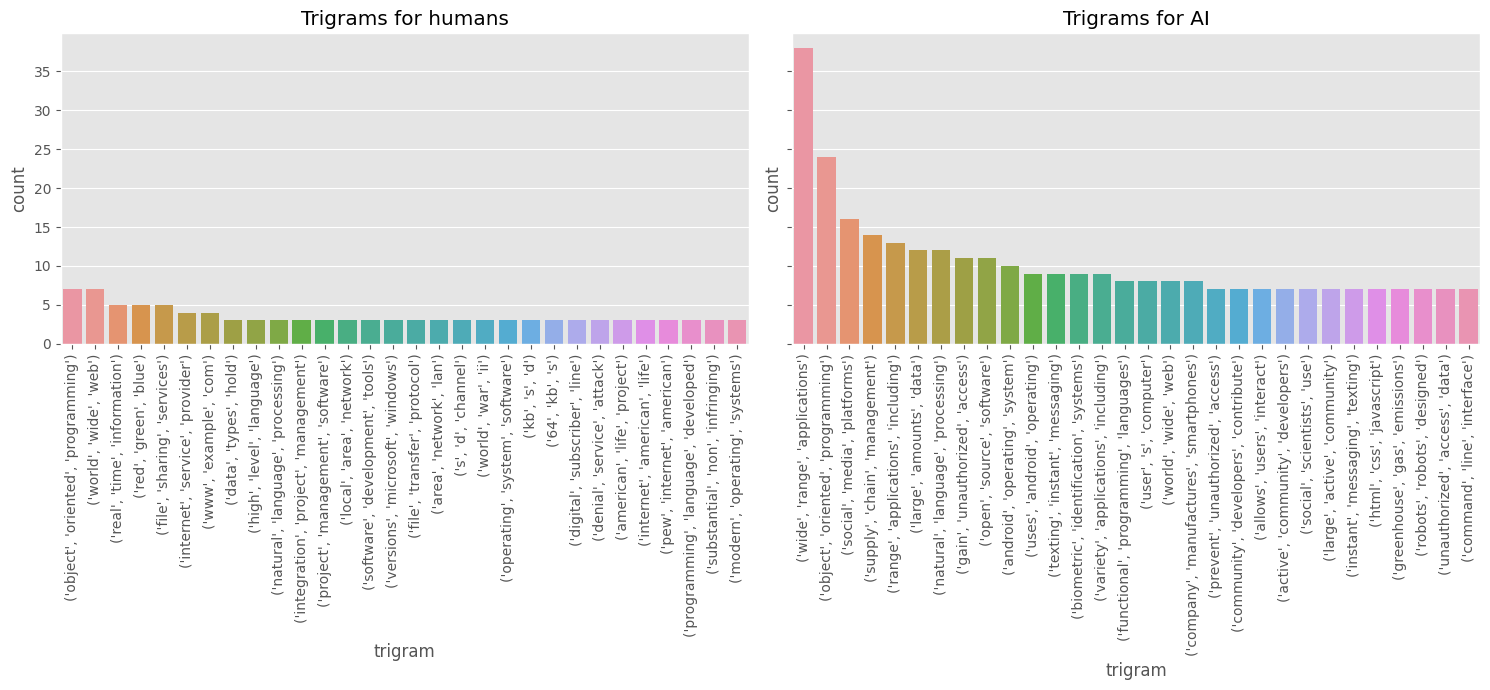

In [ ]:
trigrams_humans = (pd.Series(nltk.ngrams(corpus_humans, 3)).value_counts())
trigrams_df_h = trigrams_humans.reset_index()
trigrams_df_h.columns = ['trigram', 'count']

trigrams_AI = (pd.Series(nltk.ngrams(corpus_AI, 3)).value_counts())
trigrams_df_AI = trigrams_AI.reset_index()
trigrams_df_AI.columns = ['trigram', 'count']

fig, axes = plt.subplots(1,2, figsize = (15,7), sharey= True) 
sns.barplot(trigrams_df_h.head(30), x = 'trigram', y ='count', ax=axes[0]).set(title = 'Trigrams for humans')
sns.barplot(trigrams_df_AI.head(30), x = 'trigram', y ='count', ax=axes[1]).set(title = 'Trigrams for AI')
axes[0].tick_params(axis='x', rotation = 90)
axes[1].tick_params(axis='x', rotation = 90)
plt.tight_layout()

Let's build the feature for the 2-grams:

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from collections import Counter

In [ ]:
corpus = [word for i in data.article_clean.str.split().values.tolist() for word in i]
bigram = (pd.Series(nltk.ngrams(corpus, 2)).value_counts())
unique_bigrams = bigram.head(50).index.tolist()

In [ ]:
data['total_bigram_count'] = 0

In [ ]:
def sum_bigram_counts(row):
    words = row['article_clean'].split()
    row_bigrams = list(nltk.ngrams(words, 2))
    
    # if the bigram is one of the 50 most frequent and if it is in the row sum 1
    row_count = sum(1 for bigram in row_bigrams if bigram in unique_bigrams)
    
    row['total_bigram_count'] = row_count

    return row

In [ ]:
data = data.apply(sum_bigram_counts, axis=1)

In [ ]:
data

,Unnamed: 0,article,class,length,words,sentences,article_clean,total_bigram_count
0,0,NLP is a multidisciplinary field that draws fr...,0,1112,187,6,nlp multidisciplinary field draws linguistics ...,3
1,1,There are a variety of emerging applications f...,0,630,82,2,variety emerging applications nlp including fo...,0
2,2,As each new means of communication and social ...,0,1135,176,8,new means communication social interaction int...,0
3,3,"These suggestions include:, Learn about the pu...",0,1018,173,10,suggestions include learn purpose newsgroup po...,1
4,4,In recent years there has been growing concern...,0,699,111,3,recent years growing concern internet users ev...,1
...,...,...,...,...,...,...,...,...
1013,1013,Palettes can refer to different things dependi...,1,777,132,6,palettes refer different things depending cont...,1
1014,1014,Probability is a measure of the likelihood tha...,1,893,148,8,probability measure likelihood specific event ...,2
1015,1015,A compiler is a software program that translat...,1,1404,217,9,compiler software program translates source co...,5
1016,1016,The compilation process is the process by whic...,1,1576,238,12,compilation process process compiler translate...,3


# Features extraction

In [ ]:
# article_clean as a list, useful
data['abstract_list'] = data.abstract_nopunct.apply(str.split)


Computing the vocabulary

In [ ]:
vocabulary = Counter(reduce(lambda x,y : x+y, data.abstract_list.values))

# get the vocabulary length and its log (for Herdan's C and MaaS)
voc_len = len(vocabulary)
log_voc_len = np.log(voc_len)


In [ ]:
# Herdan's C
data['herdan'] = data.words.apply(lambda row: log_voc_len/np.log(row))

# MaaS
data['maas'] = data.words.apply(lambda row: (log_voc_len - np.log(row)) / np.log((voc_len**2)) )

# Simpson's index 
data['tf'] = data.abstract_list.apply(lambda row: Counter(row))
data['tf'] = data.tf.apply(lambda row: row.values())
simpson_help = zip(data.tf, list(data.words))
data['simpson'] = list(simpson_help)
data['simpson'] = data.simpson.apply(lambda row: [(val/row[1])**2 for val in row[0]]).apply(lambda row: 1-sum(row))

# Grammar score 
tool = language_tool_python.LanguageTool('en-US')
data['grammar_score'] = data.abstract.apply(lambda row: len(tool.check(row))) #number of errors per row
grammar_score_help = zip(data.grammar_score, data.words)
data['grammar_score'] = list(grammar_score_help)
data['grammar_score'] = data.grammar_score.apply(lambda row: (row[0]/row[1]) ) #compute grammar score

# TTR on the whole text = on 1-grams (saved as TTR1)
# for this section: type = len(tf), token = words
data['TTR1'] = list(zip(list(data.tf.apply(len)), data.words))  #assign (type, token) as value for each row
data['TTR1'] = data.TTR1.apply(lambda row: row[0]/row[1])       #compute TTR

# TTR on 2-grams, prevalence of 2grams
data['bigrams'] = data.abstract_clean.apply(str.split).apply(lambda row: nltk.ngrams(row, 2)) #create bigrams for each document
data['prevalence2'] = data.bigrams.apply(Counter                                     #count the occurency of each bigram
                                  ).apply(lambda row: (len(row), sum(row.values()) ) #returns (type, token) couple for each row
                                  ).apply(lambda row: row[0]/row[1] )                #computes TTR


#TTR on 3-grams, prevalence of trigrams
data['trigrams'] = data.abstract_clean.apply(str.split).apply(lambda row: nltk.ngrams(row, 3)) #create bigrams for each document
data['prevalence3'] = data.trigrams.apply(Counter                                    #count the occurencies of each trigram
                                  ).apply(lambda row: (len(row), sum(row.values()) ) #returns (type, token) couple for each row
                                  ).apply(lambda row: row[0]/row[1] )                #computes TTR


# Average token length 
data['avg_token_length'] = data.abstract_list.apply(lambda row: [len(word) for word in row]).apply(lambda row: sum(row)/len(row))


In [ ]:
scorer = lmppl.LM('gpt2')
